In [1]:
# ! pip install tensorflow==2.8.0
# ! pip install tensorflow_recommenders

# Summary

This notebook build upon the tutorial:

https://towardsdatascience.com/a-complete-guide-to-recommender-system-tutorial-with-sklearn-surprise-keras-recommender-5e52e8ceace1

In [2]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import utils
from collections import Counter
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_recommenders as tfrs

In [3]:
rating, user_column_index, item_column_index = utils.get_movielens_data()

rating["rating"] = rating["rating"]/5


n_users = rating["userid"].max() + 1
n_items = rating["itemid"].max() + 1
print(n_users, n_items)
train_df, test_df = utils.movielens_train_test_split(rating)
train_df.shape, test_df.shape

train_df, val_df = utils.movielens_train_test_split(train_df)
train_df.shape, val_df.shape

(100000, 4)
(1682, 24)
(943, 5)
944 1683


((98105, 49), (943, 49))

# Matrix factorization model + linear layers

In [4]:

def df_to_ds(df):
    return {
        "user_id" : tf.constant(df['userid'].values.astype(str)),
        "item_id" : tf.constant(df['itemid'].values.astype(str)),
        'rating' : tf.constant(df['rating'].tolist())
    }

In [5]:
class RankingModel(tfrs.Model):

    def __init__(self, user_id, item_id, embedding_size):
        super().__init__()
        
        # user model
        input = keras.Input(shape=(), dtype=tf.string)
        x = tf.keras.layers.StringLookup(
            vocabulary = user_id, mask_token = None
            )(input)
        output = keras.layers.Embedding(
            input_dim = len(user_id) + 1,
            output_dim = embedding_size,
            name = 'embedding'
        )(x)
        self.user_model = keras.Model(inputs = input,
                                      outputs = output,
                                      name = 'user_model')

        # item model
        input = keras.Input(shape=(), dtype=tf.string)
        x = tf.keras.layers.StringLookup(
            vocabulary = item_id, mask_token = None
            )(input)
        output = keras.layers.Embedding(
            input_dim = len(item_id) + 1,
            output_dim = embedding_size,
            name = 'embedding'
        )(x)
        self.item_model = keras.Model(inputs = input,
                                  outputs = output,
                                  name = 'item_model')

        # rating model
        concat_shape = self.user_model.layers[-1].output_shape[1] \
        + self.item_model.layers[-1].output_shape[1] 

        input = keras.Input(shape=(concat_shape,))
        x = keras.layers.Dense(256, activation = 'relu')(input)
        x = keras.layers.Dense(64, activation = 'relu')(x)
        output = keras.layers.Dense(1)(x)
        
        self.ratings = keras.Model(
            inputs = input,
            outputs = output,
            name = 'rating_model'
        )

    def call(self, inputs):

        user_id, item_id = inputs

        user_emb = self.user_model(user_id)
        item_emb = self.item_model(item_id)
        concat = tf.concat([user_emb, item_emb], axis = 1)
        prediction = self.ratings(concat)
        
        return prediction

class GMFModel(tfrs.models.Model):

    def __init__(self, user_id, item_id, embedding_size):
        super().__init__()
        self.ranking_model = RankingModel(user_id,
                                          item_id,
                                          embedding_size)
        self.task = tfrs.tasks.Ranking(
            loss = keras.losses.MeanSquaredError(),
            metrics = [keras.metrics.RootMeanSquaredError(), keras.metrics.MeanAbsoluteError()]
        )
    
    def call(self, features):
        return self.ranking_model(
            (features[0]['user_id'], features[0]['item_id'])
        )

    def compute_loss(self, features, training=False):
        label = features[0]['rating']
        return self.task(labels = label,
                         predictions = self(features))

In [6]:
# get data
train, val, test = df_to_ds(train_df), df_to_ds(val_df), df_to_ds(test_df)

In [7]:
# init model
embedding_size = 32
model = GMFModel(train_df["userid"].unique().astype(str),
                 train_df["itemid"].unique().astype(str), embedding_size)
model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=.01))

In [8]:
# fitthe model
hist = model.fit(train, epochs=10, verbose=False, validation_data=val)

# evaluate with the test data
result = model.evaluate(test, return_dict=True, verbose=0)
print("\nEvaluation on the test set:")
display(result)


Evaluation on the test set:


{'root_mean_squared_error': 0.19968903064727783,
 'mean_absolute_error': 0.1572180539369583,
 'loss': 0.03660823404788971,
 'regularization_loss': 0,
 'total_loss': 0.03660823404788971}

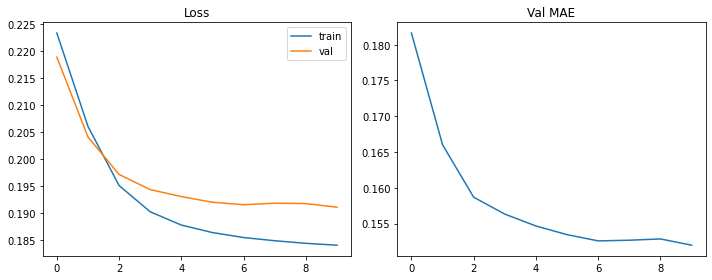

In [9]:
plt.figure(figsize = (10, 4))
plt.subplot(121)
plt.title("Loss")
plt.plot(hist.history["root_mean_squared_error"], label = "train")
plt.plot(hist.history["val_root_mean_squared_error"], label = "val")
plt.legend()
plt.subplot(122)
plt.plot(hist.history["val_mean_absolute_error"])
plt.title("Val MAE")
plt.tight_layout()

# User/item features with matrix factorization model + linear layers

In [10]:
def df_to_ds(df):
    return {
        "user_id" : tf.constant(df['userid'].values.astype(str)),
        "item_id" : tf.constant(df['itemid'].values.astype(str)),
        "user_features" : tf.constant(df[df.columns[user_column_index]].values),
        "item_features" : tf.constant(df[df.columns[item_column_index]].values),
        'rating' : tf.constant(df['rating'].tolist())
    }

In [11]:
class RankingModel(tfrs.Model):
    def __init__(self, user_id, item_id, n_user_features, n_item_features,
                 embedding_size):
        super().__init__()

        self.user_features_model = keras.Sequential([
            keras.layers.Dense(units=100,
                               activation="relu",
                               input_shape=(n_user_features, )),
            keras.layers.Dropout(0.1),
            keras.layers.Dense(units=50, activation="relu"),
            keras.layers.Dense(units=embedding_size),
        ])

        self.item_features_model = keras.Sequential([
            keras.layers.Dense(units=100,
                               activation="relu",
                               input_shape=(n_item_features, )),
            keras.layers.Dropout(0.1),
            keras.layers.Dense(units=50, activation="relu"),
            keras.layers.Dense(units=embedding_size),
        ])
        # user model
        input = keras.Input(shape=(), dtype=tf.string)
        x = tf.keras.layers.StringLookup(vocabulary=user_id,
                                         mask_token=None)(input)
        output = keras.layers.Embedding(input_dim=len(user_id) + 1,
                                        output_dim=embedding_size,
                                        name='embedding')(x)
        self.user_model = keras.Model(inputs=input,
                                      outputs=output,
                                      name='user_model')

        # item model
        input = keras.Input(shape=(), dtype=tf.string)
        x = tf.keras.layers.StringLookup(vocabulary=item_id,
                                         mask_token=None)(input)
        output = keras.layers.Embedding(input_dim=len(item_id) + 1,
                                        output_dim=embedding_size,
                                        name='embedding')(x)
        self.item_model = keras.Model(inputs=input,
                                      outputs=output,
                                      name='item_model')

        # rating model
        concat_shape = self.user_model.layers[-1].output_shape[1] \
        + self.item_model.layers[-1].output_shape[1] \
        + self.user_features_model.layers[-1].output_shape[1] \
        + self.item_features_model.layers[-1].output_shape[1]
        print(f"concat_shape {concat_shape}")

        input = keras.Input(shape=(concat_shape, ))
        x = keras.layers.Dense(400, activation='relu')(input)
        x = keras.layers.Dense(64, activation='relu')(x)
        output = keras.layers.Dense(1)(x)

        self.ratings = keras.Model(inputs=input,
                                   outputs=output,
                                   name='rating_model')

    def call(self, inputs):

        user_id, item_id, user_features, item_features = inputs

        user_emb = self.user_model(user_id)
        item_emb = self.item_model(item_id)
        user_features_emb = self.user_features_model(user_features)
        item_features_emb = self.item_features_model(item_features)
        concat = tf.concat(
            [user_emb, item_emb, user_features_emb, item_features_emb], axis=1)
        prediction = self.ratings(concat)

        return prediction


class GMFModel(tfrs.models.Model):
    def __init__(self, user_id, item_id, n_user_features, n_item_features,
                 embedding_size):
        super().__init__()
        self.ranking_model = RankingModel(user_id, item_id, n_user_features,
                                          n_item_features, embedding_size)
        self.task = tfrs.tasks.Ranking(
            loss=keras.losses.MeanSquaredError(),
            metrics=[
                keras.metrics.RootMeanSquaredError(),
                keras.metrics.MeanAbsoluteError()
            ])

    def call(self, features):
        return self.ranking_model(
            (features[0]['user_id'], features[0]['item_id'],
             features[0]['user_features'], features[0]['item_features']))

    def compute_loss(self, features, training=False):
        label = features[0]['rating']
        return self.task(labels=label, predictions=self(features))

In [12]:
train, val, test = df_to_ds(train_df), df_to_ds(val_df), df_to_ds(test_df)

In [13]:
# init model
embedding_size = 32
model = GMFModel(train_df["userid"].unique().astype(str),
                 train_df["itemid"].unique().astype(str),
                 len(user_column_index), len(item_column_index),
                 embedding_size)
model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=.01))

concat_shape 128


In [14]:
# fitting the model
hist = model.fit(train, epochs=100, verbose=False, validation_data=val)

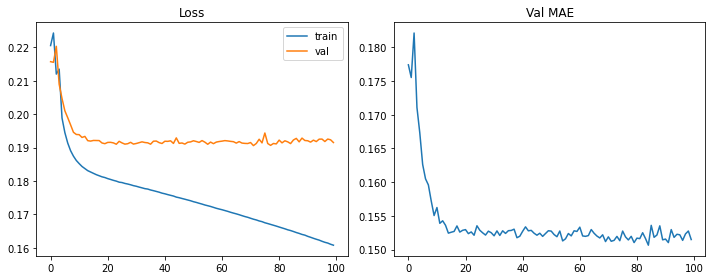

In [15]:
plt.figure(figsize = (10, 4))
plt.subplot(121)
plt.title("Loss")
plt.plot(hist.history["root_mean_squared_error"], label = "train")
plt.plot(hist.history["val_root_mean_squared_error"], label = "val")
plt.legend()
plt.subplot(122)
plt.plot(hist.history["val_mean_absolute_error"])
plt.title("Val MAE")
plt.tight_layout()

In [16]:
# evaluate with the test data
result = model.evaluate(test, return_dict=True, verbose=0)
print("\nEvaluation on the test set:")
display(result)


Evaluation on the test set:


{'root_mean_squared_error': 0.19617027044296265,
 'mean_absolute_error': 0.15373650193214417,
 'loss': 0.04174121469259262,
 'regularization_loss': 0,
 'total_loss': 0.04174121469259262}